# Importing Libraries

In [1]:
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import torchvision.transforms as standard_transforms
from torch.utils.data import DataLoader
from voc import VOC

import numpy as np

# Mapping Class to Color

In [2]:
'''
color map
0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle # 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
'''

noToClass = {
    0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car", 8:"cat", 9:"chair", 10:"cow", 11:"dining table",
12:"dog", 13:"horse", 14:"motorbike", 15:"person", 16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor"
}

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]  #3 values- R,G,B for every class. First 3 values for class 0, next 3 for

"""
    Convert palette to map class number to RGB color.

    Expected output, python dictionary with 21 integer keys, each value being a array of size 3

"""
palette_map = {
    0: [0, 0, 0], 1: [128, 0, 0], 2: [0, 128, 0], 3: [128, 128, 0], 4: [0, 0, 128], 5: [128, 0, 128], 6: [0, 128, 128],
    7: [128, 128, 128], 8: [64, 0, 0], 9: [192, 0, 0], 10: [64, 128, 0], 11: [192, 128, 0], 12: [64, 0, 128],
    13: [192, 0, 128], 14: [64, 128, 128], 15: [192, 128, 128], 16: [0, 64, 0], 17: [128, 64, 0], 18: [0, 192, 0],
    19: [128, 192, 0], 20: [0, 64, 128]
}





# Transformations to be done on images

In [3]:
# TODO Rewrite the following transformations to the ones your models are trained on.
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])

class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()
    
target_transform = MaskToTensor()

class CommonTransforms:
    """
    A class that defines common image transformations.

    Args:
        size (tuple): The desired size of the transformed image. Default is (224, 224).

    """

    def __init__(self, size=(224, 224)):
        self.size = size

    def __call__(self, img, mask):
        """
        Applies common image transformations to the input image and mask.

        Args:
            img (PIL.Image.Image): The input image.
            mask (PIL.Image.Image): The input mask.

        Returns:
            tuple: A tuple containing the transformed image and mask.

        """
        # Random horizontal flip with the same decision for both img and mask
        if random.random() > 0.5:
            img = F.hflip(img)
            mask = F.hflip(mask)

        # Random resized crop with the same parameters for both img and mask
        i, j, h, w = transforms.RandomResizedCrop.get_params(img, scale=(0.08, 1.0), ratio=(3./4., 4./3.))
        img = F.resized_crop(img, i, j, h, w, self.size, InterpolationMode.BILINEAR)
        mask = F.resized_crop(mask, i, j, h, w, self.size, InterpolationMode.NEAREST)
        img = F.to_tensor(img)
        mask = F.to_tensor(mask)
        mask = mask.to(dtype=torch.int32).long().squeeze()
        
        # Additional transformations can be added here with the same parameters for img and mask

        return img, mask


# Getting random test image and mask

In [4]:
batch_size = 1
DS = VOC('test', transform=input_transform, target_transform=target_transform)
DL = DataLoader(dataset=DS, batch_size= 1, shuffle=False)

first_batch = iter(DL)

In [5]:
img, msk = next(first_batch)

# Plotting Function

In [6]:
def makeImagesPlotReady(msk, channels = 3):
    """
    TODO 
    Similar to how you converted the images, make the mask tensor matplotlib ready

    args:
        msk or img - input mask tensor of shape [1, 3, 224, 224] or numpy of shape (3, 224, 224)
    returns:
        mask/img - mask that is ready to be plotted using matplotlib.
                    Hint: Numpy class of shape (224, 224, 3)
    """
    if isinstance(msk, torch.Tensor):
        # Check if the tensor is a batch of images or a single image
        if msk.dim() == 4:  # Assuming shape [1, channels, height, width]
            msk = msk.squeeze(0)  # Remove batch dimension
        msk = msk.permute(1, 2, 0)  # Change from [channels, height, width] to [height, width, channels]
        msk = msk.numpy()  # Convert to numpy
    elif isinstance(msk, np.ndarray) and msk.shape[0] == channels:
        print(msk.shape)
        # Assuming input is numpy of shape (channels, height, width)
        msk = np.transpose(msk, (1, 2, 0))  # Change to (height, width, channels)
        print(msk[0].max())
    else:
        raise ValueError("Input must be a PyTorch tensor or a numpy array with specified shapes.")

    return msk

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


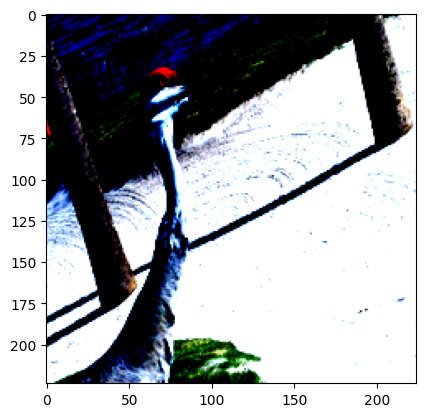

In [7]:
# Check your makeImagesPlotReady implementation by printing the img variable
plt.imshow(makeImagesPlotReady(img,3))

### Preprocessing msk

In [8]:
def convertMaskToRGB(msk_1d):
    print("mask_1d shape",msk_1d.shape)
    if type(msk_1d) == torch.Tensor:
        msk_1d = msk_1d.numpy()
        
    if len(msk_1d.shape) == 3:
        msk_1d = msk_1d[0]
    
    
    mask_rgb = np.zeros((3, 224, 224), dtype=np.uint8) # Empty array to store RGB of each class
    
    for i in range(224):
        for j in range(224):
            color = palette_map[int(msk_1d[i][j])]
            mask_rgb[0][i][j] = color[0]
            mask_rgb[1][i][j] = color[1]
            mask_rgb[2][i][j] = color[2]

    return mask_rgb

# Plotting single mask

mask_1d shape torch.Size([224, 224])
(3, 224, 224)
0


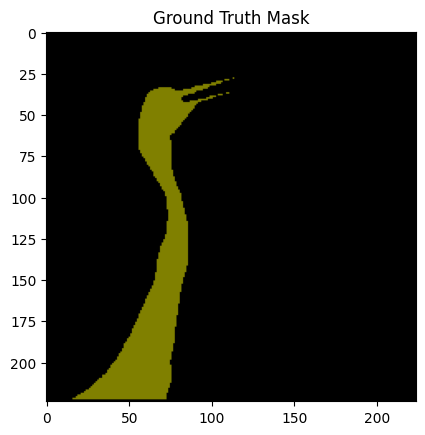

In [9]:
# Check your makeImagesPlotReady implementation by printing the msk variable

mask_rgb = convertMaskToRGB(msk[0])
plt.imshow(makeImagesPlotReady(mask_rgb,3))
plt.title("Ground Truth Mask")
plt.show()

# Running Inference on all trained models

In [10]:
"""
TODO:
The following comments are what we suggest your final 
code structure should look like for streamlined inference.
"""

# Importing all Question train files.
import train
import train_4_a
import train_4_b
import train_4_c
import train_5_a
import train_5_b
import train_5_c
numberOfModels = 7
models = ["train", "train_4_a", "train_4_b", "train_4_c", "train_5_a", "train_5_b", "train_5_c"]

True
True
True
True
True


c:\Users\16195\anaconda3\envs\ClimateBench\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\16195\anaconda3\envs\ClimateBench\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
True


In [11]:
def returnToString(arr):
    string = ""
    for i in arr:
        string += noToClass[i]
        string += ", "
    return string[:-2]

In [12]:
import torch
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


print("GROUND TRUTH CLASSES:", torch.unique(msk),"\n")

output_images = []
for model in models:
    print("Inferring Model:",model)
    output_image = eval(model).exportModel(img) # Run inference (Make sure exportModel function is imported for each train file)
    output_image = output_image.to("cpu").detach() # Remove torch components and push to cpu
    output_image = torch.argmax(output_image, dim=1) # converting softmax to OHE
    print("Model Predicted Classes:", returnToString(torch.unique(output_image).numpy()))

    mask_rgb = convertMaskToRGB(output_image)
    
    output_images.append(mask_rgb)
    

GROUND TRUTH CLASSES: tensor([0, 3]) 

Inferring Model: train


Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4_a
Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4_b
Model Predicted Classes: background
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4_c
Model Predicted Classes: background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, tv/monitor
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_5_a
Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_5_b
Model Predicted Classes: background, bird, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_5_c
Model Predicted Classes: background
mask_1d shape torch.Size([1, 224, 224])


# Plotting All outputs

## Plotting only predicted masks

Prediction Masks
(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
128
(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
0


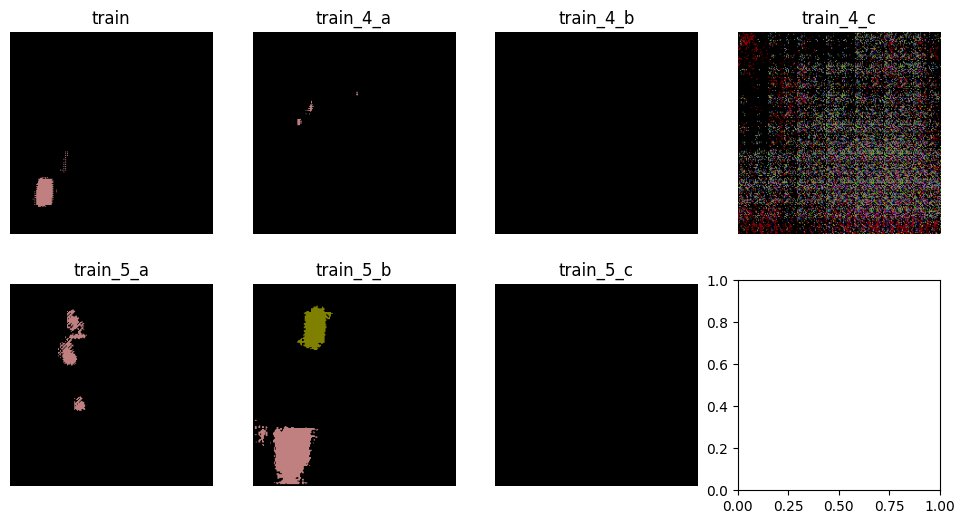

In [13]:
print("Prediction Masks")
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(numberOfModels):
    axs[i].imshow(makeImagesPlotReady(output_images[i],3))
    axs[i].set_title(models[i])
    axs[i].axis('off')

plt.show()

## Plotting image with the mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Masks


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
128
(3, 224, 224)
0
(3, 224, 224)
0
(3, 224, 224)
0


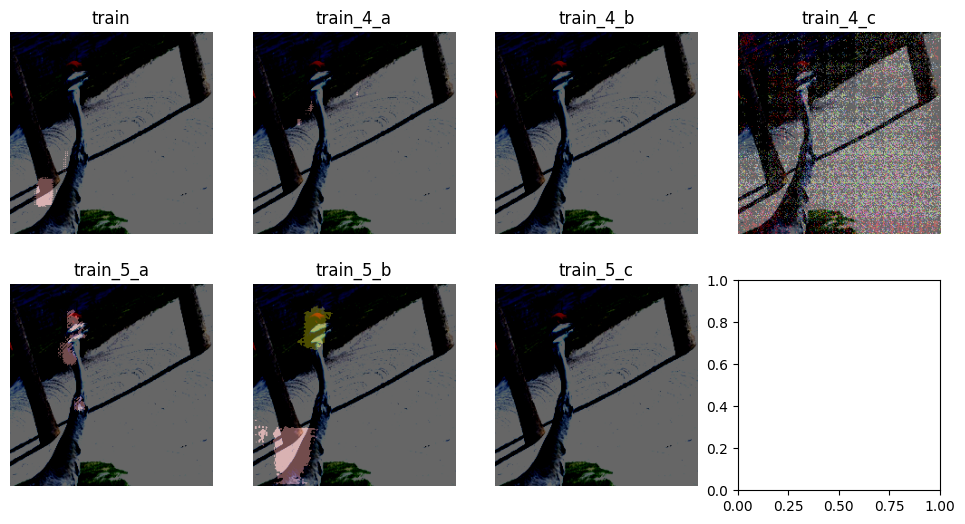

In [14]:
print("Prediction Masks")
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(numberOfModels):
    axs[i].imshow(makeImagesPlotReady(img,3))
    axs[i].imshow(makeImagesPlotReady(output_images[i],3), alpha = 0.6)
    axs[i].set_title(models[i])
    axs[i].axis('off')

plt.show()